In [116]:
import cv2
from enum import Enum
import geopy.distance
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter
import tarfile
import tensorflow as tf


class Cities(Enum):
    AMSTERDAM = "AMSTERDAM"
    CHICAGO = "CHICAGO"
    FLORENCE = "FLORENCE"
    LAS_VEGAS = "LAS_VEGAS"
    NEW_YORK = "NEW_YORK"
    PARIS = "PARIS"
    SAN_FRANCISCO = "SAN_FRANCISCO"
    WASHINGTON_DC = "WASHINGTON_DC"


class CityCoords():

    def __init__(self):
        """Initialize object to handle coordinate-related calculations."""
        self.coords = {
            Cities.AMSTERDAM: (52.3676, 4.9041),
            Cities.CHICAGO: (41.8781, -87.6298),
            Cities.FLORENCE: (43.7696, 11.2558),
            Cities.LAS_VEGAS: (36.1716, -115.1391),
            Cities.NEW_YORK: (40.7128, -74.0060),
            Cities.PARIS: (48.8566, 2.3522),
            Cities.SAN_FRANCISCO: (37.7749, -122.4194),
            Cities.WASHINGTON_DC: (38.9072, -77.0369)
        }

    def closest_city(self, unknown_coords):
        """Given the coords of an unknown city, return the closest city."""
        closest_city = None
        closest_dist = float("inf")
        for city in self.coords:
            dist = geopy.distance.geodesic(
                unknown_coords, self.coords[city]).km
            if dist < closest_dist:
                closest_dist = dist
                closest_city = city
        return closest_city


class StreetViewTarProcessor:

    def __init__(self):
        pass

    def store_tar_file(self, tar_file_name, dest_path, max_img_to_save=float("inf"), resize_data=None, grayscale=False):
        """
        Given a path to a tar file containing Street View data, vectorizes images and compresses them to .npz binary file.
            tar_file_name: The path of the tar file. Ex: "./0002.tar"
            dest_path: The path for the .npz file to be stored at. Ex: "./VectorFiles/0002"
            max_img_to_save: The number of images that should be saved. If unspecified, all images are saved.
            resize_data: If unspecified, images are 640x640. If specified, resizes data to dimension. Ex: resize_data=32 (32x32 img)
            grayscale: Determines if images should be stored as grayscale.
        """

        # Open tar file.
        tar = tarfile.open(tar_file_name)
        print(f"Opened tarfile {tar_file_name}.")

        # Validate tar members.
        unvalidated_tar_members = {m.name: m for m in tar.getmembers()}
        valid_member_names = self._get_valid_member_names(
            unvalidated_tar_members)
        print(
            f"Validated {len(valid_member_names)} tar members from tarfile {tar_file_name}.")

        # Sample a tar member to determine the city of the dataset.
        sample_valid_member = next(iter(valid_member_names))
        sample_f = tar.extractfile(
            unvalidated_tar_members[sample_valid_member+".txt"])
        city = self._retrieve_city(sample_f.read().decode("utf-8"))

        # Preserve only .jpg data, discarding .txt data.
        if max_img_to_save > len(valid_member_names):
            max_img_to_save = len(valid_member_names)
        valid_jpg_names = [m for m in unvalidated_tar_members if m[:-4]
                           in valid_member_names and m.endswith(".jpg")]

        img_vectors = []
        for i in range(max_img_to_save):
            img_vector = plt.imread(tar.extractfile(
                unvalidated_tar_members[valid_jpg_names[i]]))
            if resize_data:
                img_vector = cv2.resize(img_vector, dsize=(
                    resize_data, resize_data), interpolation=cv2.INTER_AREA)
            # converts image to grayscale and extends vectors
            if grayscale:
                img_vector = cv2.cvtColor(img_vector, cv2.COLOR_RGB2GRAY)
                img_vector = np.expand_dims(img_vector, -1)
                img_vector = img_vector.repeat(3, axis=-1)
            img_vectors.append(img_vector)

        print(
            f"Processed {len(img_vectors)} image vectors from tarfile {tar_file_name}.")

        # Store as a compressed binary file.
        np.savez_compressed(f"{dest_path}-{city.value}",
                            np.asarray(img_vectors))
        print(
            f"Saved data from tarfile {tar_file_name} to {dest_path}-{city.value}.")

        tar.close()

    def load_tar_file(self, input_path):
        """Given a path to a .npz file containing Street View data, extracts the data."""
        return np.load(input_path)['arr_0']

    def display_img_from_vector(self, img_vector, is_grayscale=False):
        """Given an image vector, displays the image."""
        if is_grayscale:
            plt.imshow(img_vector, cmap="gray")
        else:
            plt.imshow(img_vector, interpolation="nearest")
        plt.show()

    def gaussian_blur(self, img_vector, sigma, convert_to_grayscale):
        """Given an image vector, returns an image vector with a gaussian blur of intensity sigma applied."""
        if convert_to_grayscale:
            return gaussian_filter(img_vector, sigma)
        return gaussian_filter(img_vector, sigma=(sigma,sigma,0))

    def _retrieve_city(self, text_data):
        """Given a tar member name, returns the city associated with the tar file."""
        # Extract coordinates from some image. All images in single tar file have same city.
        google_metadata = text_data.split("\n")[0]
        coords = tuple([float(coord)
                       for coord in google_metadata.split()[11:13]])

        # Determine closest city.
        return CityCoords().closest_city(coords)

    def _get_valid_member_names(self, tar_members):
        """Given tar members, find and return valid txt-jpg pairs."""
        tar_names = list(tar_members.keys())
        valid_tar_member_names = set()
        while len(tar_names) > 0:
            tar_name = tar_names[-1]

            # Check that ending is valid -- either jpg or txt.
            if not (tar_name.endswith(".jpg") or tar_name.endswith(".txt")):
                tar_names.pop()
                continue

            # Try to find match -- members should come in txt-jpg pairs.
            target_name = tar_name[:-3] + \
                "txt" if tar_name.endswith(".jpg") else tar_name[:-3] + "jpg"
            try:
                i = tar_names.index(target_name)

            except:
                tar_names.pop()
                continue

            # Tar members form valid pair.
            valid_tar_member_names.add(tar_name[:-4])
            tar_names.pop(i)
            tar_names.pop()

        return valid_tar_member_names

In [139]:
processor = StreetViewTarProcessor()
processor.store_tar_file(
        "/Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york/0069.tar", "/Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york", 250, grayscale = False)
processor.store_tar_file(
        "/Users/samanthabastien/PycharmProjects/final project/fpd/main data/washington dc/0002.tar", "/Users/samanthabastien/PycharmProjects/final project/fpd/main data/washington dc", 250, grayscale = False)

Opened tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york/0069.tar.
Validated 232846 tar members from tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york/0069.tar.
Processed 250 image vectors from tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york/0069.tar.
Saved data from tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york/0069.tar to /Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york-NEW_YORK.
Opened tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/washington dc/0002.tar.
Validated 63026 tar members from tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/washington dc/0002.tar.
Processed 250 image vectors from tarfile /Users/samanthabastien/PycharmProjects/final project/fpd/main data/washington dc/0002.tar.
Saved data from tarfile /Users/samanthabastien/PycharmProjects/final project

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

# Library for Transfer Learning
from tensorflow.keras.applications import resnet50

In [141]:
class_names=os.listdir("/Users/samanthabastien/PycharmProjects/final project/fpd/main data/")
class_names

['new york-NEW_YORK.npz',
 '.DS_Store',
 'washington dc-WASHINGTON_DC.npz',
 'new york',
 'washington dc']

In [142]:
# deletes unneeded class
class_names.remove('.DS_Store')
class_names

['new york-NEW_YORK.npz',
 'washington dc-WASHINGTON_DC.npz',
 'new york',
 'washington dc']

In [143]:
y=[] # to store the labels of the images
z=[]

In [146]:
#paths where npz files are stored
path1 = "/Users/samanthabastien/PycharmProjects/final project/fpd/main data/new york/new york-NEW_YORK-250.npz"
path2 = "/Users/samanthabastien/PycharmProjects/final project/fpd/main data/washington dc/washington dc-WASHINGTON_DC-250.npz"

In [147]:
vectors1 = np.load(path1, allow_pickle=True)['arr_0']
np.random.shuffle(vectors1)
train_x1, val_x1 = np.split(vectors1, 2)


train_y1 = y[:len(y)//2]
train_y2 = y[len(y)//2:]

vectors2 = np.load(path2, allow_pickle=True)['arr_0']
np.random.shuffle(vectors2)
train_x2, val_x2 = np.split(vectors2, 2)


train_x = np.concatenate((train_x1, train_x2), axis=0)
val_x = np.concatenate((val_x1, val_x2), axis=0)
train_z1 = z[:len(z)//2]
train_z2 = z[len(z)//2:]



In [148]:
train_x.shape

(250, 640, 640, 3)

In [149]:
for index in range(np.size(train_x, axis=0)):
    y.append(class_names.index('new york'))
for index in range(np.size(train_x, axis=0)):
    z.append(class_names.index('washington dc'))
train_y1 = y[:len(y)//2]
val_y1 = y[len(y)//2:]  
train_z1 = z[:len(z)//2]
val_z2 = z[len(z)//2:]

train_y = train_y1+ train_z1
val_y = val_y1 + val_z2


    
len(y)

250

In [150]:
# Verifying the output

# Training Dataset
print("Training Dataset")

train_y=to_categorical(train_y) # onehot encoding of the labels
print(train_y.shape)

Training Dataset
(250, 4)


In [151]:
# we are using resnet50 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import resnet50

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_resnet=resnet50.ResNet50(weights='imagenet')

In [152]:
input_layer=layers.Input(shape=(640,640,3))

In [153]:
from keras.layers import Dropout

In [154]:
# initialize the transfer model ResNet50 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the ResNet50 using input_tensor
# 3) we want to change the last layer so we are not including top layer
resnet_model=resnet50.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)


In [155]:
last_layer=resnet_model.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 


# Add dense layer
dense1=layers.Dense(100,activation='relu')(flatten)
x = layers.Dropout(0.2)(dense1)
# Add dense layer to the final output layer
output_layer=layers.Dense(2,activation='softmax')(x)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

In [156]:
for layer in model.layers[:-1]:
    layer.trainable=False

In [158]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(train_x,train_y,test_size=0.2,random_state=5)

print("Splitting data for train and test completed.")

Splitting data for train and test completed.


In [159]:
print(xtrain.shape)
print(ytrain.shape)

(200, 640, 640, 3)
(200, 4)


In [160]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Model compilation completed.")

Model compilation completed.


In [161]:
data = model.fit(xtrain,ytrain,epochs=20,batch_size=64,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")

Epoch 1/20


ValueError: in user code:

    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/samanthabastien/opt/anaconda3/lib/python3.9/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 2) are incompatible


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


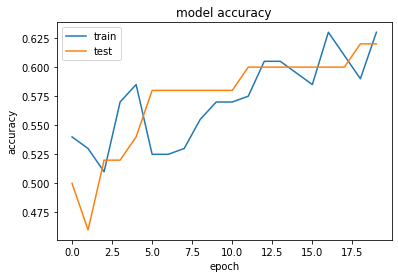

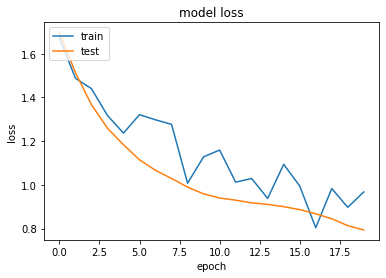

In [138]:
# creates graphs
print(data.history.keys())
# summarize history for accuracy
plt.plot(data.history['accuracy'])
plt.plot(data.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()